In [121]:
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from PIL import Image
import numpy as np
import os
import re
import random

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
dataset_path = "/content/drive/MyDrive/BTP/text_image_dataset"
csv_path = "labels.csv"

In [123]:
import pandas as pd
data = pd.read_csv(csv_path)
print(data.head())

                      filename   font
0  font_0_sample_0_size_16.png  Arial
1  font_0_sample_1_size_16.png  Arial
2  font_0_sample_2_size_16.png  Arial
3  font_0_sample_3_size_16.png  Arial
4  font_0_sample_4_size_16.png  Arial


In [124]:
def extract_label_from_filename(filename):
    match = re.match(r'font_(\d+)_sample_\d+_size_(\d+)', filename)
    if match:
        font_class = int(match.group(1))
        size = int(match.group(2))
        return font_class, size
    return None, None

In [125]:
fonts = ["Arial", "Times New Roman", "Courier New", "Verdana", "Georgia"]
font_to_label = {font: idx for idx, font in enumerate(fonts)}

images = []
font_labels = []
size_labels = []

for index, row in data.iterrows():
    image_path = os.path.join(dataset_path, row['filename'])

    if os.path.exists(image_path):
        img = Image.open(image_path).convert("L")
        img = img.resize((32, 32))
        img = np.array(img) / 255.0

        # Extract font and size
        font_class, size = extract_label_from_filename(row['filename'])
        if font_class is not None and size is not None:
            images.append(img)
            font_labels.append(font_class)
            size_labels.append(size)

images = np.array(images).reshape(-1, 32, 32, 1)
font_labels = to_categorical(font_labels, num_classes=len(fonts))
size_labels = np.array(size_labels)
size_labels = np.array(size_labels) / 32.0

x_train, x_test, y_font_train, y_font_test, y_size_train, y_size_test = train_test_split(
    images, font_labels, size_labels, test_size=0.2, random_state=42
)

print(f"Total images: {len(images)}")
print(f"Train set: {len(x_train)}, Test set: {len(x_test)}")
print(f"First font label (one-hot): {y_font_train[0]}")
print(f"First size label: {y_size_train[0]}")

Total images: 300
Train set: 240, Test set: 60
First font label (one-hot): [0. 0. 0. 1. 0.]
First size label: 1.0


In [126]:
original_sizes = (size_labels * 32.0).astype(int)  # Convert back to 16, 24, 32
font_indices = np.argmax(font_labels, axis=1)  # Convert one-hot back to indices

# Create combined labels for stratification
# Combine font and size into a single label like "Arial_16", "Arial_24", etc.
combined_strata = [f"{fonts[f]}_{s}" for f, s in zip(font_indices, original_sizes)]

# Perform stratified split
x_train, x_test, y_font_train, y_font_test, y_size_train, y_size_test = train_test_split(
    images,
    font_labels,
    size_labels,
    test_size=0.2,
    random_state=42,
    stratify=combined_strata
)

# Verify the distribution
def print_distribution(y_font, y_size, split_name):
    font_dist = np.sum(y_font, axis=0)
    size_dist = (y_size * 32.0).astype(int)

    print(f"\n{split_name} Distribution:")
    print("\nFont Distribution:")
    for idx, count in enumerate(font_dist):
        print(f"{fonts[idx]}: {count} ({count/len(y_font)*100:.1f}%)")

    print("\nSize Distribution:")
    for size in [16, 24, 32]:
        count = np.sum(size_dist == size)
        print(f"{size}px: {count} ({count/len(y_size)*100:.1f}%)")

# Print distributions for both splits
print_distribution(y_font_train, y_size_train, "Training")
print_distribution(y_font_test, y_size_test, "Test")

print(f"\nTrain set: {len(x_train)}, Test set: {len(x_test)}")


Training Distribution:

Font Distribution:
Arial: 48.0 (20.0%)
Times New Roman: 48.0 (20.0%)
Courier New: 48.0 (20.0%)
Verdana: 48.0 (20.0%)
Georgia: 48.0 (20.0%)

Size Distribution:
16px: 80 (33.3%)
24px: 80 (33.3%)
32px: 80 (33.3%)

Test Distribution:

Font Distribution:
Arial: 12.0 (20.0%)
Times New Roman: 12.0 (20.0%)
Courier New: 12.0 (20.0%)
Verdana: 12.0 (20.0%)
Georgia: 12.0 (20.0%)

Size Distribution:
16px: 20 (33.3%)
24px: 20 (33.3%)
32px: 20 (33.3%)

Train set: 240, Test set: 60


In [127]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

def build_lenet():
    inputs = layers.Input(shape=(32, 32, 1))

    x = layers.Conv2D(6, (5, 5), activation='relu', padding='valid',
                     kernel_initializer=tf.keras.initializers.HeNormal(seed=seed),
                     kernel_regularizer=l2(0.01))(inputs)
    x = layers.AveragePooling2D((2, 2))(x)

    x = layers.Conv2D(16, (5, 5), activation='relu', padding='valid',
                     kernel_initializer=tf.keras.initializers.HeNormal(seed=seed),
                  kernel_regularizer=l2(0.01))(x)
    x = layers.AveragePooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(120, activation='relu',
                    kernel_initializer=tf.keras.initializers.HeNormal(seed=seed),
                  kernel_regularizer=l2(0.01))(x)
    x = layers.Dense(84, activation='relu',
                    kernel_initializer=tf.keras.initializers.HeNormal(seed=seed),
                  kernel_regularizer=l2(0.01))(x)

    font_output = layers.Dense(len(fonts), activation='softmax', name='font_output',
                             kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    size_output = layers.Dense(1, activation='linear', name='size_output',
                             kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)

    model = tf.keras.Model(inputs=inputs, outputs=[font_output, size_output])
    return model

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - font_output_accuracy: 0.1594 - font_output_loss: 1.6705 - loss: 6.2098 - size_output_loss: 0.0957 - size_output_mae: 0.2516 - val_font_output_accuracy: 0.2500 - val_font_output_loss: 1.5974 - val_loss: 5.7515 - val_size_output_loss: 0.0417 - val_size_output_mae: 0.1775 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - font_output_accuracy: 0.2357 - font_output_loss: 1.5959 - loss: 5.6599 - size_output_loss: 0.0465 - size_output_mae: 0.1820 - val_font_output_accuracy: 0.2833 - val_font_output_loss: 1.5892 - val_loss: 5.3462 - val_size_output_loss: 0.0356 - val_size_output_mae: 0.1596 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - font_output_accuracy: 0.3454 - font_output_loss: 1.5747 - loss: 5.2506 - size_output_loss: 0.0394 - size_output_mae: 0.1689 - val_font_output_accuracy: 0.3833 - val_font_output_loss: 1.5727 - val_loss: 4.9844 - val_size_output_loss: 0.0365 - val_size_outpu

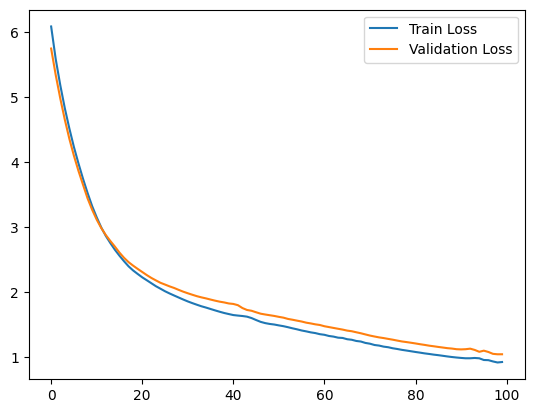

In [128]:
model = build_lenet()

model.compile(
    optimizer="adam",
    loss={"font_output": "categorical_crossentropy", "size_output": "mse"},
    metrics={"font_output": "accuracy", "size_output": "mae"}
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  # Reduce LR by half
    patience=3,  # Wait for 3 epochs before reducing LR
    min_lr=1e-5  # Minimum LR limit
)

# Train the model
history = model.fit(
    x_train, {"font_output": y_font_train, "size_output": y_size_train},
    validation_data=(x_test, {"font_output": y_font_test, "size_output": y_size_test}),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [129]:
test_results = model.evaluate(
    x_test, {"font_output": y_font_test, "size_output": y_size_test}
)
print(f"Test Results: {test_results}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - font_output_accuracy: 0.8910 - font_output_loss: 0.3912 - loss: 1.0170 - size_output_loss: 0.0054 - size_output_mae: 0.0580
Test Results: [1.0385109186172485, 0.41460078954696655, 0.005074231885373592, 0.8833333253860474, 0.056623782962560654]


In [130]:
predictions = model.predict(x_test)

font_predictions = predictions[0]
size_predictions = predictions[1]

predicted_font_indices = np.argmax(font_predictions, axis=1).flatten()
actual_font_indices = np.argmax(y_font_test, axis=1).flatten()

predicted_sizes = size_predictions.flatten() * 32.0
actual_sizes = y_size_test.flatten() * 32.0

fonts = ["Arial", "Times New Roman", "Courier New", "Verdana", "Georgia"]
label_to_font = {idx: font for idx, font in enumerate(fonts)}

predicted_font_names = [label_to_font[idx] for idx in predicted_font_indices]
actual_font_names = [label_to_font[idx] for idx in actual_font_indices]

n_samples = 10
df_results = pd.DataFrame({
    "Actual Font": actual_font_names[:n_samples],
    "Predicted Font": predicted_font_names[:n_samples],
    "Actual Size (px)": actual_sizes[:n_samples].astype(int),
    "Predicted Size (px)": predicted_sizes[:n_samples].astype(int)
})

print(df_results)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
       Actual Font   Predicted Font  Actual Size (px)  Predicted Size (px)
0          Verdana          Verdana                32                   27
1          Verdana          Verdana                16                   17
2  Times New Roman  Times New Roman                16                   17
3  Times New Roman  Times New Roman                32                   28
4          Verdana          Verdana                32                   27
5      Courier New      Courier New                32                   27
6      Courier New      Courier New                24                   24
7          Georgia          Georgia                24                   23
8      Courier New      Courier New                24                   25
9            Arial            Arial                24                   23
